### Préparation des features pour la modélisation

A réaliser :
* Si ce n'est pas déjà fait, supprimer toutes les colonnes peu pertinentes pour la modélisation.
* Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer.
* Débarrassez-vous des features redondantes en utilisant une matrice de corrélation de Pearson. Pour cela, utiisez la méthode corr() de Pandas, couplé d'un graphique Heatmap de la librairie Seaborn 
* Réalisez différents graphiques pour comprendre le lien entre vos features et la TARGET (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé).
*  Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre TARGET).
* Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne. Les deux méthodes d'encodage à connaitre sont le OneHotEncoder et le LabelEncoder

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from category_encoders import BinaryEncoder

import sys
import importlib
sys.path.append("..")
import config
importlib.reload(config)  # Ensure we get the latest TARGET value
from config import TARGET

In [21]:
# Load the dataset

building_consumption = pd.read_csv("../assets/building_consumption_post_feature_engineering.csv")
building_consumption.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,NumberOfUseTypes,NumberofFloors_quintile,SteamUse,NaturalGas,Electricity,EraBuilt
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,Compliant,NaN,249.98,2.83,1,Q5,1,1,1,≤1930
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,Compliant,NaN,295.86,2.86,3,Q5,0,1,1,1991-2010
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,Compliant,NaN,2089.28,2.19,1,Q5,1,1,1,1951-1970
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,Compliant,NaN,286.43,4.67,1,Q5,1,1,1,≤1930
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,Compliant,NaN,505.01,2.88,3,Q5,0,1,1,1971-1990


#### Matrice de corrélation

TotalGHGEmissions                  1.000000
SiteEnergyUseWN(kBtu)              0.884307
SiteEnergyUse(kBtu)                0.881552
Electricity(kWh)                   0.676477
NaturalGas(therms)                 0.601914
LargestPropertyUseTypeGFA          0.556729
NumberofBuildings                  0.539629
PropertyGFABuilding(s)             0.497541
PropertyGFATotal                   0.458368
SecondLargestPropertyUseTypeGFA    0.423712
GHGEmissionsIntensity              0.393990
ThirdLargestPropertyUseTypeGFA     0.332546
SiteEUI(kBtu/sf)                   0.296863
SiteEUIWN(kBtu/sf)                 0.292710
SteamUse                           0.259930
SourceEUI(kBtu/sf)                 0.243372
SourceEUIWN(kBtu/sf)               0.239004
NaturalGas                         0.094475
PropertyGFAParking                 0.091454
NumberOfUseTypes                   0.045729
CouncilDistrictCode                0.038432
Longitude                          0.037267
Latitude                        

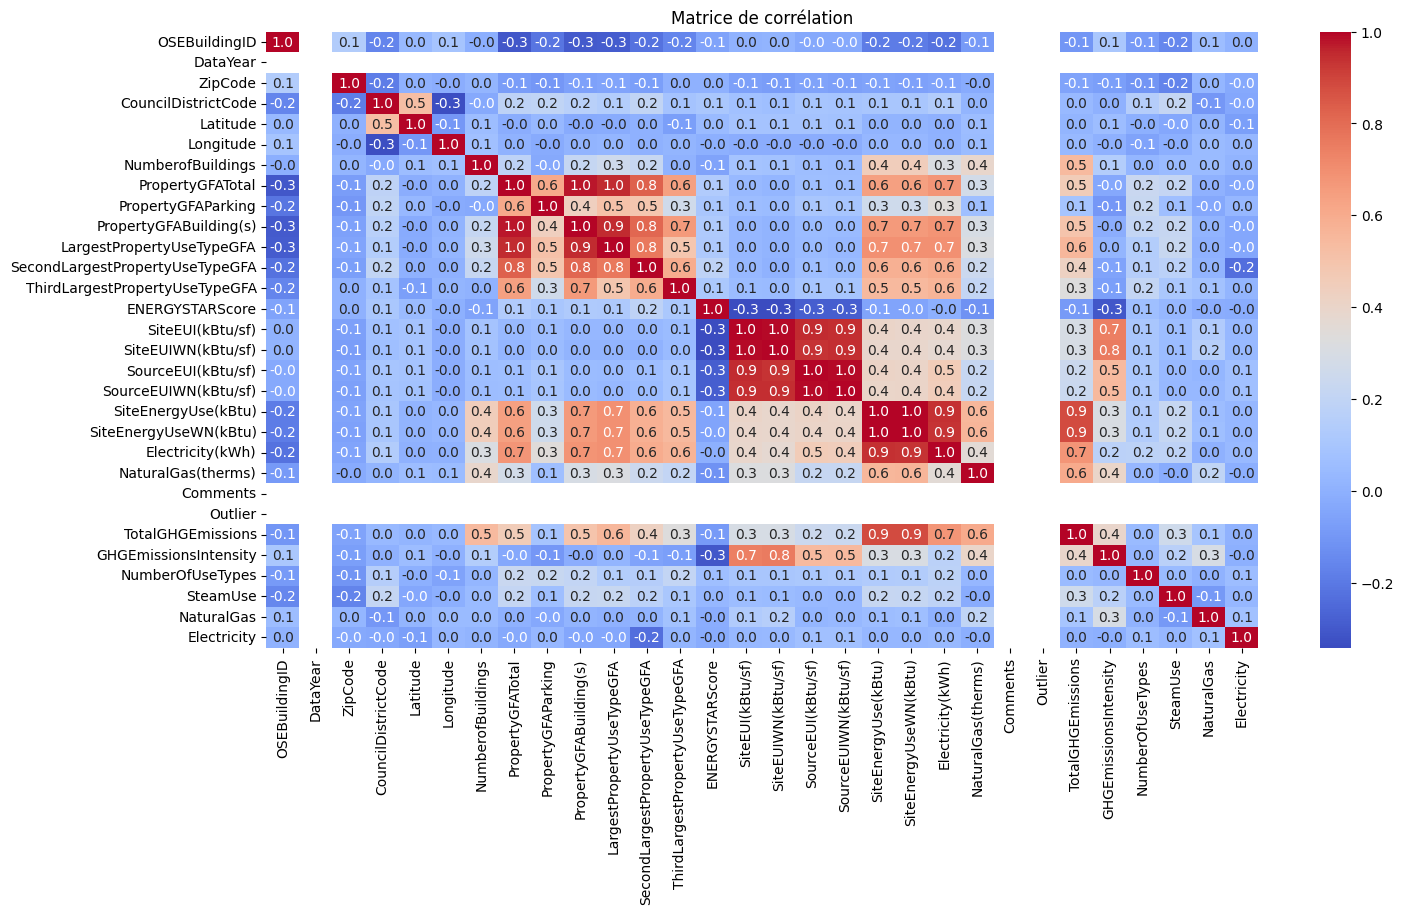

In [22]:
num_cols = building_consumption.select_dtypes(include="number")
corr_matrix = num_cols.corr()
print(corr_matrix[TARGET].sort_values(ascending=False))
plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()

# Une fois la TARGET choisie, quelles features supprimer ?
# Suppression des features très corrélées avec la TARGET (corr > 0.7) ? > 0 A CONFIRMER
# Ne pas garder à la fois PropertyGFABuilding(s), PropertyGFAParking et PropertyGFATotal ? Supprimer Total ?

### Suppression des colonnes

In [23]:
### Suppression des colonnes
cols_to_drop = [
    "OSEBuildingID",
    "Comments",
    "DataYear",
    "TaxParcelIdentificationNumber",
    "State",
    "DefaultData",
    "NaturalGas(therms)",
    "Electricity(kWh)",
    "SiteEUI(kBtu/sf)",
    "SiteEUIWN(kBtu/sf)",
    "SiteEnergyUse(kBtu)",
    "SiteEnergyUseWN(kBtu)",
    "SourceEUI(kBtu/sf)",
    "SourceEUIWN(kBtu/sf)",
    "GHGEmissionsIntensity",
    "ListOfAllPropertyUseTypes",  # Supprimé car trop de modalités différentes, et géré par Feature engineering
    "LargestPropertyUseType",
	"SecondLargestPropertyUseType",
	"ThirdLargestPropertyUseType",
	"YearsENERGYSTARCertified",
    "Outlier",
    "City",
    "PropertyName",
    "Address",
    "Neighborhood",  # CouncilDistrict plus précis
    "Longitude",
    "Latitude",
    "ComplianceStatus",
    "ZipCode",
]
existing_cols = [col for col in cols_to_drop if col in building_consumption.columns]
building_consumption.drop(columns=existing_cols, inplace=True)
# building_consumption.columns
num_cols = building_consumption.select_dtypes(include="number")
corr_matrix = num_cols.corr()
print(corr_matrix[TARGET].sort_values(ascending=False))

TotalGHGEmissions                  1.000000
LargestPropertyUseTypeGFA          0.556729
NumberofBuildings                  0.539629
PropertyGFABuilding(s)             0.497541
PropertyGFATotal                   0.458368
SecondLargestPropertyUseTypeGFA    0.423712
ThirdLargestPropertyUseTypeGFA     0.332546
SteamUse                           0.259930
NaturalGas                         0.094475
PropertyGFAParking                 0.091454
NumberOfUseTypes                   0.045729
CouncilDistrictCode                0.038432
Electricity                        0.007946
ENERGYSTARScore                   -0.087581
Name: TotalGHGEmissions, dtype: float64


### Encodage binaire de la feature PrimaryPropertyType

In [24]:
encoder = BinaryEncoder()
primary_property_type_encoded = encoder.fit_transform(
	building_consumption[["PrimaryPropertyType"]]
)
primary_property_type_encoded.shape
building_consumption = pd.concat(
    [building_consumption, primary_property_type_encoded], axis=1  # type: ignore
)
building_consumption.drop(columns=["PrimaryPropertyType"], inplace=True)
building_consumption.head()

,BuildingType,CouncilDistrictCode,NumberofBuildings,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,...,NumberofFloors_quintile,SteamUse,NaturalGas,Electricity,EraBuilt,PrimaryPropertyType_0,PrimaryPropertyType_1,PrimaryPropertyType_2,PrimaryPropertyType_3,PrimaryPropertyType_4
0,NonResidential,7,1.0,88434,0,88434,88434.0,NaN,NaN,60.0,...,Q5,1,1,1,≤1930,0,0,0,0,1
1,NonResidential,7,1.0,103566,15064,88502,83880.0,15064.0,4622.0,61.0,...,Q5,0,1,1,1991-2010,0,0,0,0,1
2,NonResidential,7,1.0,956110,196718,759392,756493.0,NaN,NaN,43.0,...,Q5,1,1,1,1951-1970,0,0,0,0,1
3,NonResidential,7,1.0,61320,0,61320,61320.0,NaN,NaN,56.0,...,Q5,1,1,1,≤1930,0,0,0,0,1
4,NonResidential,7,1.0,175580,62000,113580,123445.0,68009.0,0.0,75.0,...,Q5,0,1,1,1971-1990,0,0,0,0,1


### One-hot encoding sur BuildingType

In [25]:
# Features à encoder
features_to_encode = ["BuildingType", "NumberofFloors_quintile", "EraBuilt"]

In [26]:
for feature in features_to_encode : 
	print(building_consumption[feature].nunique())
	print(building_consumption[feature].value_counts())

4
BuildingType
NonResidential        1445
SPS-District K-12       97
Nonresidential COS      84
Nonresidential WA        1
Name: count, dtype: int64
5
NumberofFloors_quintile
Q1    471
Q2    376
Q5    275
Q3    262
Q4    243
Name: count, dtype: int64
6
EraBuilt
≤1930        413
1951-1970    404
1991-2010    332
1971-1990    319
1931-1950    111
Post-2010     48
Name: count, dtype: int64


In [27]:
enc = OneHotEncoder(sparse_output=False, drop="first")

for feature in features_to_encode:
    # Fit + transform
    encoded_cat = enc.fit_transform(building_consumption[[feature]])

    # Récupérer les noms des colonnes encodées
    encoded_df = pd.DataFrame(
        encoded_cat,
        columns=enc.get_feature_names_out([feature]),
        index=building_consumption.index,  # 🔑 garder les bons index
    )

    # Concatener avec le dataset
    building_consumption = pd.concat([building_consumption, encoded_df], axis=1)

    # Supprimer l’ancienne colonne
    building_consumption.drop(columns=[feature], inplace=True)

building_consumption.head()

,CouncilDistrictCode,NumberofBuildings,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,TotalGHGEmissions,...,BuildingType_SPS-District K-12,NumberofFloors_quintile_Q2,NumberofFloors_quintile_Q3,NumberofFloors_quintile_Q4,NumberofFloors_quintile_Q5,EraBuilt_1951-1970,EraBuilt_1971-1990,EraBuilt_1991-2010,EraBuilt_Post-2010,EraBuilt_≤1930
0,7,1.0,88434,0,88434,88434.0,NaN,NaN,60.0,249.98,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,7,1.0,103566,15064,88502,83880.0,15064.0,4622.0,61.0,295.86,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,7,1.0,956110,196718,759392,756493.0,NaN,NaN,43.0,2089.28,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,7,1.0,61320,0,61320,61320.0,NaN,NaN,56.0,286.43,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,7,1.0,175580,62000,113580,123445.0,68009.0,0.0,75.0,505.01,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [28]:
# Identifier les features catégorielles
cat_cols = building_consumption.select_dtypes(include="object").columns.tolist()
print("Colonnes catégorielles :", cat_cols)

Colonnes catégorielles : []


Skewness de TotalGHGEmissions : 14.26
Kurtosis de TotalGHGEmissions : 258.32


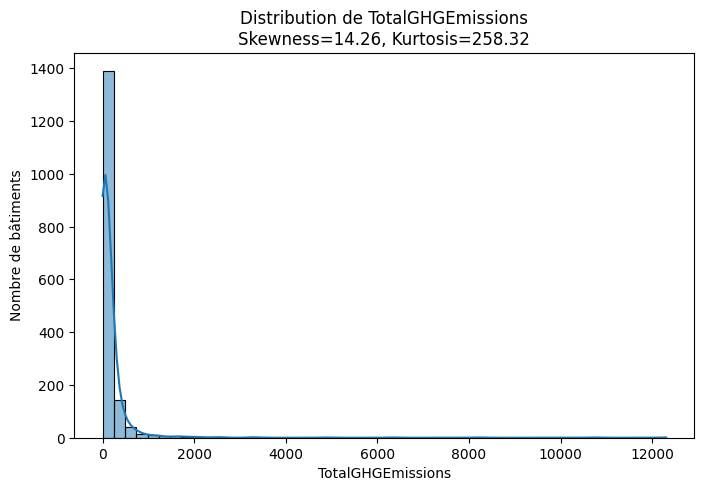

In [29]:
# Calcul skewness et kurtosis
skewness = building_consumption[TARGET].skew()
kurtosis = building_consumption[TARGET].kurt()

print(f"Skewness de {TARGET} : {skewness:.2f}")
print(f"Kurtosis de {TARGET} : {kurtosis:.2f}")

# Histogramme
plt.figure(figsize=(8, 5))
sns.histplot(building_consumption[TARGET], bins=50, kde=True)
plt.title(f"Distribution de {TARGET}\nSkewness={skewness:.2f}, Kurtosis={kurtosis:.2f}")
plt.xlabel(TARGET)
plt.ylabel("Nombre de bâtiments")
plt.show()

In [30]:
# Identification des items sans données concernant les émissions de GES, puis suppression
building_consumption[building_consumption[TARGET].isna()]
building_consumption = building_consumption[~building_consumption[TARGET].isna()]
print(
    "Nombre de bâtiments restants (après suppression des NaN) :",
    building_consumption.shape[0],
)

Nombre de bâtiments restants (après suppression des NaN) : 1625


### Identification des outliers (z-score > 3)

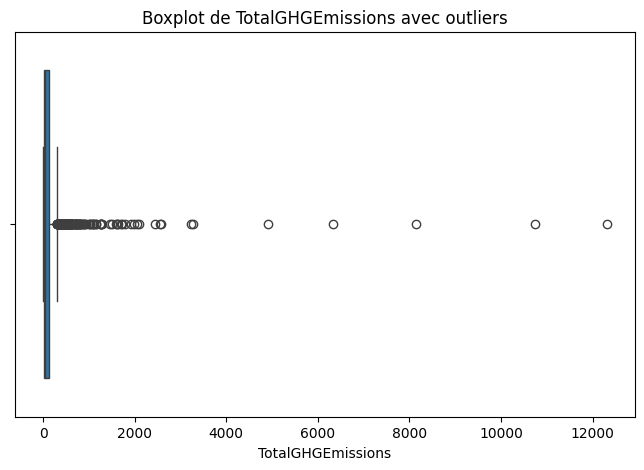

In [31]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=building_consumption[TARGET])
plt.title(f"Boxplot de {TARGET} avec outliers")
plt.show()

#### Z-score

In [32]:
# Calcul des Z-scores (en ignorant les NaN)
z_scores = stats.zscore(building_consumption[TARGET].dropna())

# Transformer en Series avec les bons index
z_scores = pd.Series(z_scores, index=building_consumption[TARGET].dropna().index)

# Sélection des outliers
outliers_z = building_consumption.loc[z_scores.abs() > 3, TARGET]

# Résumé
n_outliers = len(outliers_z)
pct_outliers = n_outliers / building_consumption.shape[0] * 100

print(f"Nombre d'outliers (Z-score) : {n_outliers}")
print("% d'outliers par rapport au dataset total : {:.2f}%".format(pct_outliers))
# Récupérer les détails complets des bâtiments outliers
outliers_details = building_consumption.loc[outliers_z.index]

# Afficher les 10 plus grands outliers avec toutes les colonnes utiles
display(outliers_details.sort_values(by=TARGET, ascending=False).head(10))

Nombre d'outliers (Z-score) : 14
% d'outliers par rapport au dataset total : 0.86%


,CouncilDistrictCode,NumberofBuildings,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,TotalGHGEmissions,...,BuildingType_SPS-District K-12,NumberofFloors_quintile_Q2,NumberofFloors_quintile_Q3,NumberofFloors_quintile_Q4,NumberofFloors_quintile_Q5,EraBuilt_1951-1970,EraBuilt_1971-1990,EraBuilt_1991-2010,EraBuilt_Post-2010,EraBuilt_≤1930
596,3,7.0,1765970,0,1765970,1639334.0,441551.0,NaN,54.0,12307.16,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
164,3,9.0,1158691,0,1158691,1350182.0,387651.0,NaN,29.0,10734.57,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
121,4,6.0,879000,0,879000,879000.0,NaN,NaN,10.0,8145.52,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1582,3,1.0,374466,0,374466,1010135.0,NaN,NaN,74.0,6330.91,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
161,3,6.0,597519,0,597519,601615.0,48607.0,NaN,34.0,4906.33,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1034,5,8.0,415632,0,415632,483520.0,266833.0,NaN,85.0,3278.11,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1037,3,1.0,591981,0,591981,520187.0,282392.0,54159.0,60.0,3238.24,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
250,7,1.0,542305,0,542305,542305.0,0.0,NaN,45.0,2573.75,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1544,3,1.0,178000,0,178000,181930.0,NaN,NaN,NaN,2549.47,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
47,7,1.0,994212,146694,847518,994212.0,117668.0,0.0,63.0,2451.58,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [33]:
# Si besoin d'inspecter un bâtiment en particulier
building_consumption.loc[596]

CouncilDistrictCode                      3.00
NumberofBuildings                        7.00
PropertyGFATotal                   1765970.00
PropertyGFAParking                       0.00
PropertyGFABuilding(s)             1765970.00
LargestPropertyUseTypeGFA          1639334.00
SecondLargestPropertyUseTypeGFA     441551.00
ThirdLargestPropertyUseTypeGFA            NaN
ENERGYSTARScore                         54.00
TotalGHGEmissions                    12307.16
NumberOfUseTypes                         2.00
SteamUse                                 1.00
NaturalGas                               1.00
Electricity                              1.00
PrimaryPropertyType_0                    0.00
PrimaryPropertyType_1                    1.00
PrimaryPropertyType_2                    1.00
PrimaryPropertyType_3                    0.00
PrimaryPropertyType_4                    1.00
BuildingType_Nonresidential COS          0.00
BuildingType_Nonresidential WA           0.00
BuildingType_SPS-District K-12    

#### IQR

Nombre d'outliers (IQR) : 174
% d'outliers par rapport au dataset total : 10.71%


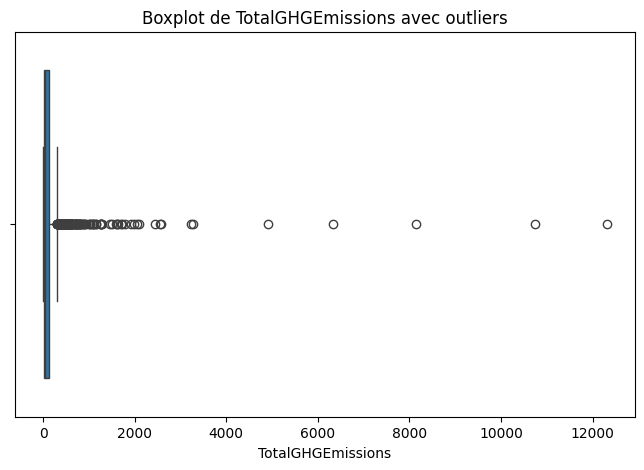

In [34]:
Q1 = building_consumption[TARGET].quantile(0.25)
Q3 = building_consumption[TARGET].quantile(0.75)
IQR = Q3 - Q1

# Bornes
borne_inf = Q1 - 1.5 * IQR
borne_sup = Q3 + 1.5 * IQR

# Outliers (hors bornes)
outliers_iqr = building_consumption.loc[
    (building_consumption[TARGET] < borne_inf)
    | (building_consumption[TARGET] > borne_sup),
    TARGET,
]

print(f"Nombre d'outliers (IQR) : {len(outliers_iqr)}")
print(
    "% d'outliers par rapport au dataset total : {:.2f}%".format(
        len(outliers_iqr) / building_consumption.shape[0] * 100
    )
)
outliers_iqr.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.boxplot(x=building_consumption[TARGET])
plt.title(f"Boxplot de {TARGET} avec outliers")
plt.show()

### Nettoyage des valeurs manquantes

In [35]:
# Vérification des valeurs manquantes
print("Valeurs manquantes par colonne :")
missing_values = building_consumption.isnull().sum()
missing_features = missing_values[missing_values > 0]
print(missing_features)

if len(missing_features) > 0:
    print(f"\nNombre total de valeurs manquantes : {missing_values.sum()}")
    print(f"Pourcentage de valeurs manquantes : {(missing_values.sum() / building_consumption.size) * 100:.2f}%")
else:
    print("Aucune valeur manquante détectée.")
    
print(f"\nShape avant nettoyage : {building_consumption.shape}")

Valeurs manquantes par colonne :
LargestPropertyUseTypeGFA             4
SecondLargestPropertyUseTypeGFA     788
ThirdLargestPropertyUseTypeGFA     1281
ENERGYSTARScore                     547
dtype: int64

Nombre total de valeurs manquantes : 2620
Pourcentage de valeurs manquantes : 5.20%

Shape avant nettoyage : (1625, 31)


In [36]:
# Pour ENERGYSTARScore : pas besoin d'effectuer une imputation par la médiane (score énergétique) car le score médian dans la définition est de 50

building_consumption.loc[
    building_consumption["ENERGYSTARScore"].isna(), "ENERGYSTARScore"
] = 50


# Vérification finale
total_missing_after = building_consumption.isnull().sum().sum()
print(f"\nNombre total de valeurs manquantes après nettoyage : {total_missing_after}")
print(f"Shape après nettoyage : {building_consumption.shape}")


Nombre total de valeurs manquantes après nettoyage : 2073
Shape après nettoyage : (1625, 31)


In [37]:
### Dataset final nettoyé
building_consumption.to_csv(
    "../assets/building_consumption_cleaned.csv", index=False
)
print(f"Dataset sauvegardé avec {building_consumption.shape[0]} lignes et {building_consumption.shape[1]} colonnes")
print("Aucune valeur manquante restante")

Dataset sauvegardé avec 1625 lignes et 31 colonnes
Aucune valeur manquante restante
